# BATDOG

### *The <font color=red>B</font>ayesian <font color=red>A</font>s<font color=red>t</font>rometric <font color=red>D</font>ust Cart<font color=red>og</font>rapher*

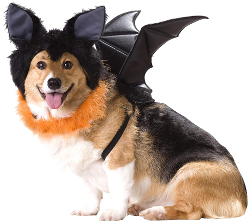

**A Python notebook for processing of parallaxes, comparison with variable star distances and inference of line of sight interstellar extinction to said variable stars.**

------

## Contents

#### 1. Imports/dependencies
#### 2. Loading of data
#### 3. Setup of priors
#### 4. Running of emcee
#### 5. Data saving and plotting

------

# 1. Imports and dependencies

Specify directories

In [1]:
# Directory where we can find data for plotting
data_dir = 'data/'

Import packages

In [2]:
# Packages you probably have:
import numpy as np
from scipy.optimize import fmin  # for some data loading shiz
from scipy.stats import norm
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Packages you might not have:
import emcee

# Local .py files that should be in the same dir as this notebook:
# <none>

# 2. Loading of data

## Creation of PLR relation class
We define a PLR relation class with a number of useful methods. Each instance stores its own PLR parameters.

In [3]:
class PLR:
    # Dependencies
    import numpy as np
    
    def __init__(self):
        """Create a, b dictionaries local to each instance for storing PLR parameters."""
        self.a = {}
        self.b = {} 
        
    def check_is_list(self, test):
        """Little function for making things lists if they aren't already."""
        if type(test) is not list or np.ndarray:
            return [test]
        else:
            return test
    
    def set_band(self, new_a, new_b, band='default'):
        """Sets the specified band. Defaults to setting it for a single default band.
        It is entirely possible to pass a list of bands to this method for easy assignment.
        """
        # Typecast inputs as lists if necessary so we can iterate over them
        band = self.check_is_list(band)
        new_a = self.check_is_list(new_a)
        new_b = self.check_is_list(new_b)
               
        # Iterate over input bands and set a, b.
        for a_band, a_new_a, a_new_b in zip(band, new_a, new_b):      
            self.a[a_band] = float(a_new_a)
            self.b[a_band] = float(a_new_b)
    
    def read_band_a(self, band='default'):
        """Reads the specified band a value back to the user."""
        return self.a[band]
    
    def read_band_b(self, band='default'):
        """Reads the specified band b value back to the user."""
        return self.b[band]
    
    def list_of_bands(self):
        """Returns a list of currently loaded bands in a.
        It is assumed that self.a and self.b will always have the same keys,
        at least for proper assignment with the class' set_band method.
        """
        return list(self.a.keys())
        
    # The following are applications of the Leavitt law.
    def magnitude(self, period, band='default'):
        """Returns the apparent magnitude of a variable given a period."""
        return self.a[band] * (np.log10(period) - 1) + self.b[band]
    
    def period(self, magnitude, band='default'):
        """Returns the period of a variable given an apparent magnitude."""
        return np.power(10, (magnitude - self.b[band]) / self.a[band] + 1)

## Setup of a fake distribution
Create a fake data distribution, fuck with it, and go from there.
Try to sample stars from a unifrom density:

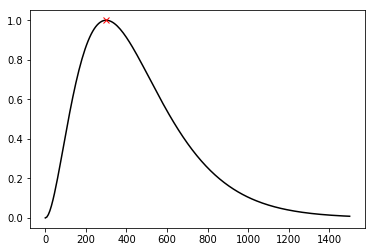

In [4]:
def true_parallax(r):
    """Returns what the exact true parallax should be in arcsecs for a given r."""
    return 1.0/r
    

def stellar_distribution(r, L, fact=1):
    """Returns pdf of a decreasing volume density distribution.
    L = scale length
    fact = in case we need the -ve of the function and as a factor too to normalise it
    """
    return fact/(2*L**3) * r**2 * np.exp(-r/L)


# Set some parameters
N = 2000  # number of stars
scale = 150  # scale factor in pc to apply, roughly half the mode of the pdf

# Work out the maximum of our distribution
pdf_max_x = fmin(stellar_distribution, scale*2, args=(scale, -1), disp=False)
pdf_max_y = stellar_distribution(pdf_max_x, scale)

# Normalise the distribution to have its max at 1 for sampling
factor = 1.0 / pdf_max_y 

# Quick test of the distribution
hi = np.linspace(0, scale*10, num=200)
plt.plot(hi, stellar_distribution(hi, scale, fact=factor), 'k-')
plt.plot([pdf_max_x], stellar_distribution(pdf_max_x, scale, fact=factor), 'rx')
plt.show()

Let's sample the real location of the stars

In [5]:
# Some bits of setup of objects
rng = np.random.RandomState(42)  # Use a defined start number for repeatability
sampled_ids = pd.Series(list(range(0, N)))
data = pd.DataFrame(sampled_ids, columns=['ID'])  # Everything we care about will be in here

# Assign a random ra and dec to every star
data['ra'] = pd.Series(np.random.rand(N) * 360)
data['dec'] = pd.Series((np.random.rand(N) - 0.5)*180)

# Sample the pdf to get good values for r
i = 0
r_true = np.zeros(N)
while i < N:
    # Create a test r of size 13 times that of the scale and a deviate test_p to cf with the interval
    test_r = np.random.rand() * scale * 13
    test_p = np.random.rand()
    
    # See if the test point is in the distribution or not
    if test_p < stellar_distribution(test_r, scale, fact=factor):
        r_true[i] = test_r
        i += 1

# Assign the r values we've got to the data frame
data['r_true'] = pd.Series(r_true)
data['omega_true'] = pd.Series(1 / r_true)

## Assigning stellar parameters to the distribution
Let's make two PL relations to use; a real one and an experimentally derived one.

In [6]:
real_PLR = PLR()
real_PLR.set_band(-2.7, 3.0)

test_PLR = PLR()
test_PLR.set_band(-2.75, 3.1)

Use the PL relation to infer values for things like magnitude and luminosity.

In [7]:
# Make up some stuff
# data['stellar_r_true'] = pd.Series((2-0.1)*np.random.rand(N) + 0.1)
data['P_true'] = pd.Series((20-5)*np.random.rand(N) + 5)
data['M_true'] = pd.Series(real_PLR.magnitude(data['P_true']))
data['m_true'] = pd.Series(data['M_true'] + 5*np.log10(data['r_true'] / 10))

## Sampling experimental values

Now, let's sample some experimental values. **TODO: define an $r^2e^{-r}$ function to act as a model of the distribution of fractional errors on parameters:**

In [8]:
def error_distribution(value, max_error, min_error):
    """Currently just pulls out a random number *roughly* between max_error and min_error."""
    random_numbers = np.random.rand(value.size) * (max_error - min_error) + min_error
    return value * random_numbers

Next, we want to mess with all of our true values and generate some experimental ones to play with.

In [9]:
# to get deviates, do something like:
# (1 + a_gaussian_deviate(mean=0, s=something)) * true_value
# equivalent to:
# a_gaussian_deviate(mean=1, s=something) * true_value

# Setup some experimental values. 
# Currently, errors on experimental values are just the actual real ones but slightly messed with.
rng = np.random.RandomState(142)  # Use a defined start number for repeatability

# Parallax
parallax_errors = data['omega_true'] * np.random.normal(loc=0, scale=0.4, size=N)
data['omega_exp'] = data['omega_true'] + parallax_errors
data['omega_sigma'] = np.abs(parallax_errors) + 0.2  # the extra 0.2 is to make sure no error bars are zero
                                         
# Apparent magnitude
app_magnitude_errors = data['m_true'] * np.random.normal(loc=0, scale=0.01, size=N)
data['m_exp'] = data['m_true'] + app_magnitude_errors
data['m_sigma'] = np.abs(app_magnitude_errors) + 0.1

# Period
period_errors = data['P_true'] * np.random.normal(loc=0, scale=0.1, size=N)
data['P_exp'] = data['P_true'] + period_errors
data['P_sigma'] = np.abs(period_errors) + 0.1

# Inferred absolute magniture from the test PLR
### THIS CURRENTLY JUST USES INPUT ERROR - needs knowledge of relationship error also
data['M_exp'] = pd.Series(test_PLR.magnitude(data['P_exp']))
data['M_exp_l'] = pd.Series(test_PLR.magnitude(data['P_exp'] + data['P_sigma'])) # data['M_exp'] - 
data['M_exp_u'] = pd.Series(test_PLR.magnitude(data['P_exp'] - data['P_sigma']))# - data['M_exp'])

# Inferred radii from the test PLR
data['r_exp'] = np.power(10, (data['m_exp']-data['M_exp'])/5 + 1)
data['r_exp_u'] = np.power(10, (data['m_exp']+data['m_sigma']-data['M_exp_l'])/5 + 1)
data['r_exp_l'] = np.power(10, (data['m_exp']-data['m_sigma']-data['M_exp_u'])/5 + 1)

# 3. Setup of priors

## The distance prior
Currently, this just uses a prior akin to Bailer-Jones 2018 (i.e. a decreasing volume density prior, ideal for the MW.)